In [137]:
import csv
import os

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import h5netcdf
import earthaccess
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import pyinterp.backends.xarray  # Module that handles the filling of undefined values.
import pyinterp.fill
import seaborn as sns
import dask.array as da
from   dask.distributed import Client
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import matplotlib
import matplotlib.colors as colors
from matplotlib import lines
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker 
import cartopy.mpl.ticker as cticker
import pandas as pd
from matplotlib.widgets import TextBox
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches
from matplotlib import cm

# Now PACE datasets mapped on to AMT

In [183]:
df_PACE_cphyto  = pd.read_csv('Tables/phyto_carbon_monthly_stats_unnormalized.csv')
df_PACE_chla  = pd.read_csv('Tables/chla_monthly_stats_unnormalized.csv')
df_PACE_poc  = pd.read_csv('Tables/poc_monthly_stats_unnormalized.csv')


# we need to remove some outlieres:
df_PACE_cphyto.loc[df_PACE_cphyto['mean'] > 200, 'mean']=np.nan
df_PACE_poc.loc[df_PACE_poc['mean'] > 250, 'mean']=np.nan
df_PACE_chla.loc[df_PACE_chla['mean'] > 2, 'mean']=np.nan

df_PACE_chla

,month_year,Lat,Lon,cv,mean,median,std,value
0,Apr 2024,-48.199,-52.692,0.117412,0.357765,0.338076,0.042006,chlor_a
1,Apr 2024,-48.115,-52.572,0.087586,0.366482,0.360107,0.032099,chlor_a
2,Apr 2024,-48.014,-52.436,0.160421,0.391770,0.375639,0.062848,chlor_a
3,Apr 2024,-47.933,-52.353,0.178919,0.379481,0.334546,0.067896,chlor_a
4,Apr 2024,-47.860,-52.236,0.212918,0.365566,0.372546,0.077835,chlor_a
...,...,...,...,...,...,...,...,...
8927,Sep 2024,11.790,-27.795,0.068735,0.139984,0.142469,0.009622,chlor_a
8928,Sep 2024,11.976,-27.841,0.136587,0.137541,0.137541,0.018786,chlor_a
8929,Sep 2024,12.355,-27.937,0.151994,0.145452,0.159962,0.022108,chlor_a
8930,Sep 2024,6.256,-26.381,0.000000,0.173372,0.173372,0.000000,chlor_a


# Let's start with making simple plots of BGC vs. latitude

In [181]:
# Extract and sort month names
def PACE_lat_plots(df,v):
  df["month_dt"] = pd.to_datetime(df["month_year"], format="%b %Y")
  df["month_name"] = df["month_dt"].dt.strftime("%b")
  df["month_num"] = df["month_dt"].dt.month

# Sort months chronologically
  months_sorted = (
    df[["month_year", "month_name", "month_num"]]
    .drop_duplicates()
    .sort_values("month_num")
    .reset_index(drop=True)
)
  month_ordered = months_sorted["month_name"].tolist()

# Assign a consistent color to each month name
  colors = cm.viridis(np.linspace(0, 1, len(month_ordered)))
  month_color_map = dict(zip(month_ordered, colors))

# Sorted list of unique month_year labels (for subplot titles)
  months = months_sorted["month_year"].tolist()

# Set up facet layout
  ncols = 4
  nrows = int(np.ceil(len(months) / ncols))
  fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 10), sharex=True, sharey=True)
  axes = axes.flatten()

# Plot each month
  for i, month in enumerate(months):
    ax = axes[i]
    
    plot_data = df[df["month_year"] == month]
    month_name = plot_data["month_name"].iloc[0]
    color = month_color_map[month_name]
    
    ax.errorbar(
        plot_data["mean"],
        plot_data["Lat"],
        xerr=plot_data["std"],
        fmt="o",
        color=color,
        ecolor="lightgray",
        elinewidth=1,
        capsize=2,
        markersize=3
    )
    
    ax.set_title(month, fontsize=10)
    if i % ncols == 0:
        ax.set_ylabel("Latitude")
    if i >= len(axes) - ncols:
        ax.set_xlabel(v)

# Remove any unused subplots
  for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

  plt.suptitle("PACE "+v+" ± SD by Month", fontsize=16)
  plt.tight_layout(rect=[0, 0, 1, 0.95])
  plt.show()

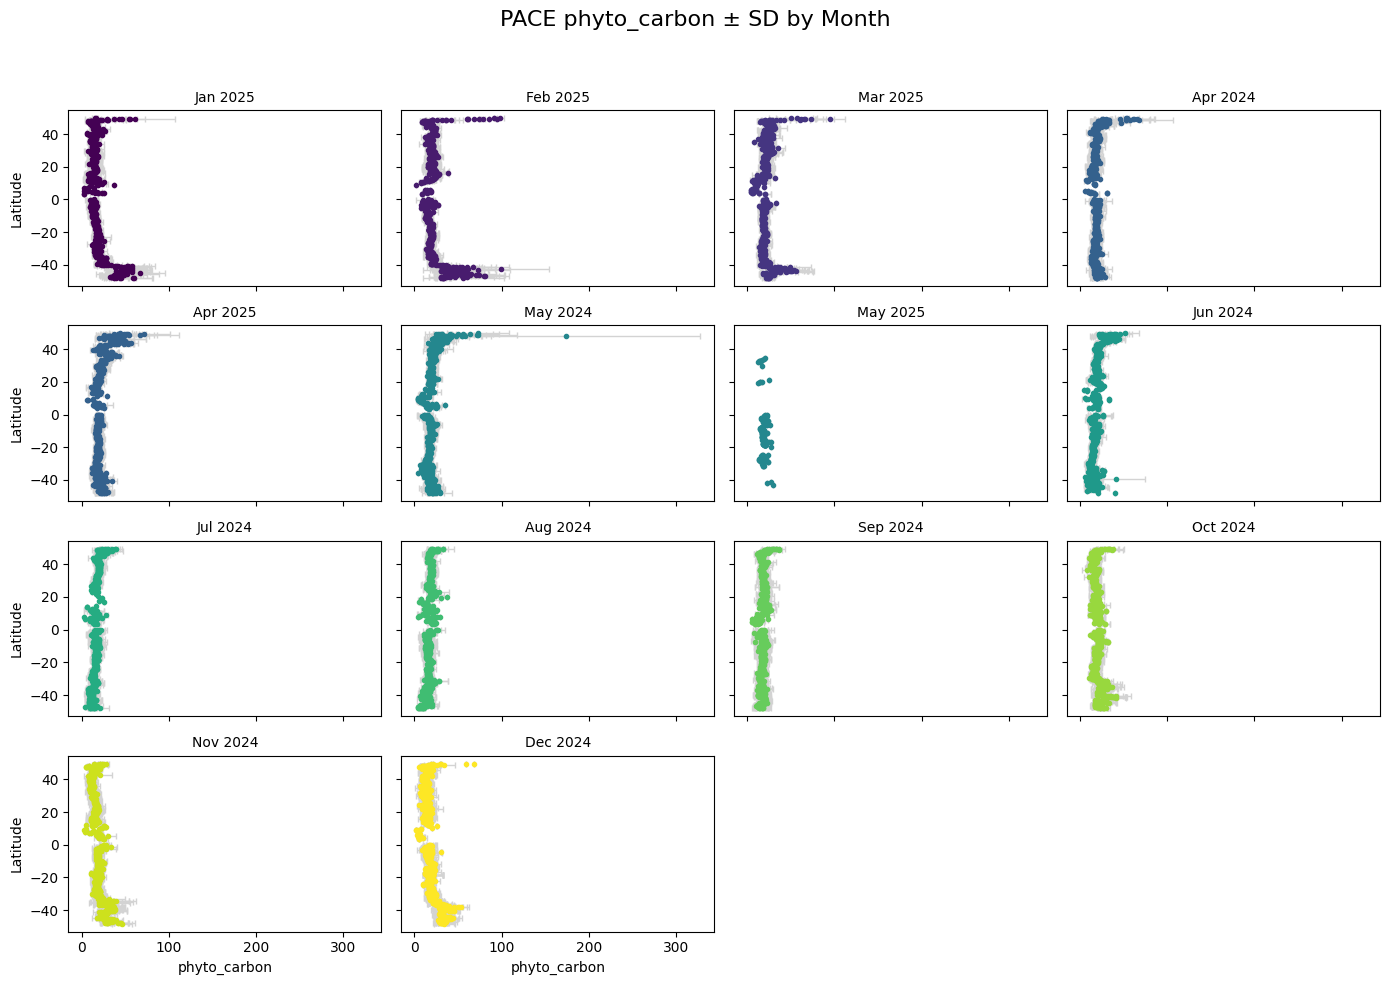

In [213]:
PACE_lat_plots(df_PACE_cphyto,'phyto_carbon')

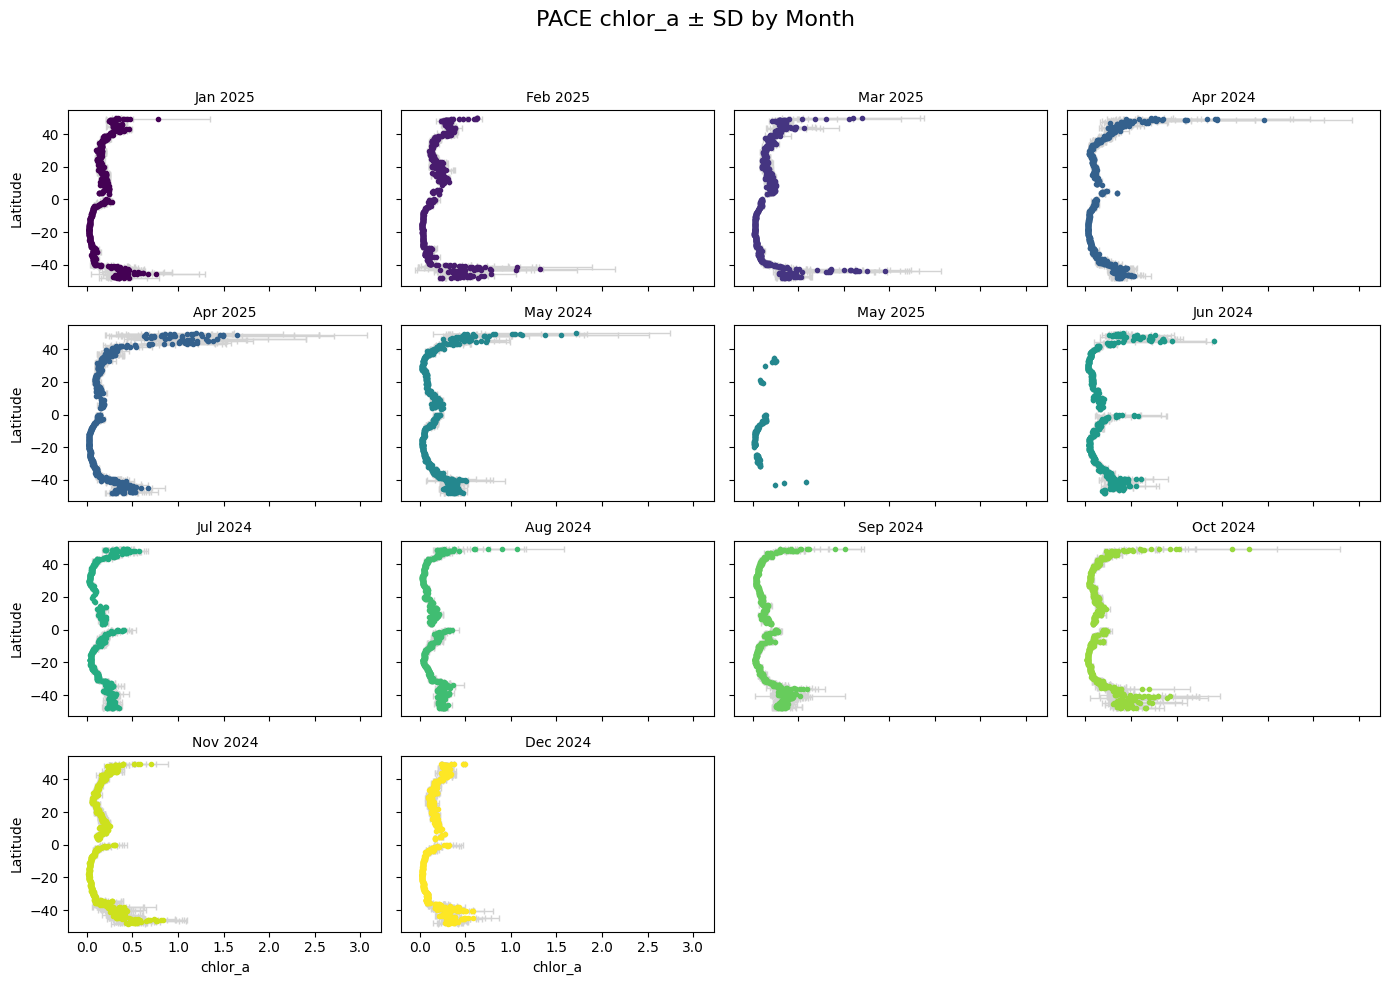

In [214]:
PACE_lat_plots(df_PACE_chla,'chlor_a')


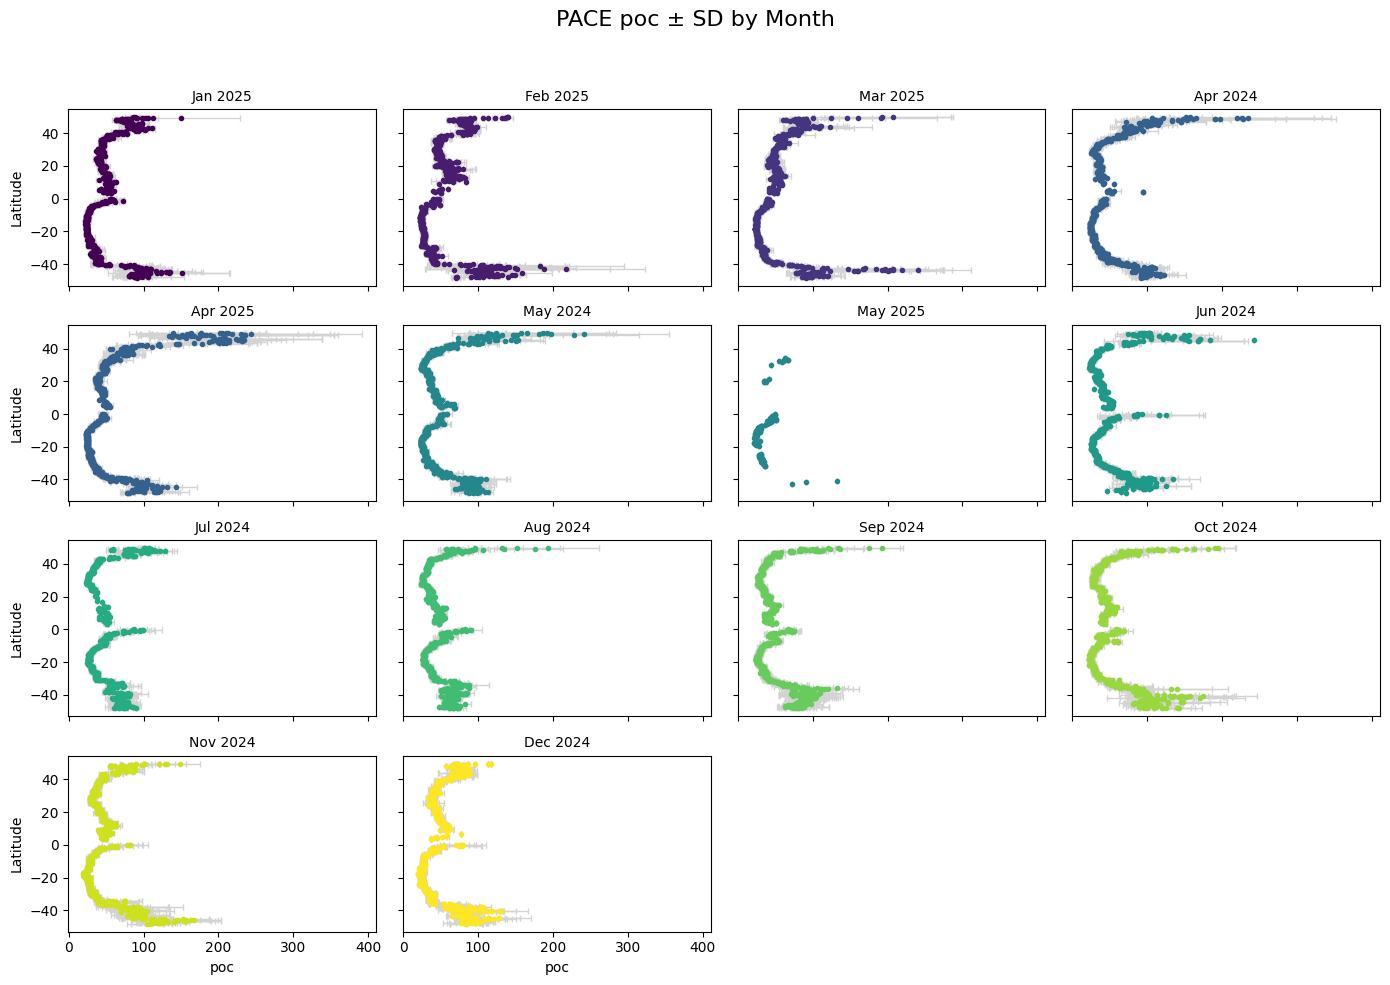

In [215]:
PACE_lat_plots(df_PACE_poc,'poc')

In [211]:
def pca_AMT_pace(df):
  M = df.to_numpy()
# remove rows with nans and keep track of the indices
  nan_rows_mask = np.isnan(M).any(axis=1)
# Create a mask for valid rows (rows without NaN)
  valid_rows_mask = ~nan_rows_mask
# Extract the cleaned array
  Mclean = M[valid_rows_mask]
# Get the original indices of the valid rows
  original_indices = np.where(valid_rows_mask)[0]
# Get the  indices of the vinalid rows
  nan_indices = np.where(nan_rows_mask)[0]
  M=Mclean
  pca = PCA(n_components=3)
  pca.fit(M)
  print(pca.explained_variance_ratio_)
  print(pca.singular_values_)
  df_pcomp = pd.DataFrame(data = pca.components_,columns = df.columns.values)
  return nan_indices,original_indices,df_pcomp

In [119]:
# Create the Data matrix (make sure it is standardized)

In [187]:
df_PACE_cphyto['zscore'] = (df_PACE_cphyto['mean'] - df_PACE_cphyto['mean'].mean())/df_PACE_cphyto['mean'].std()

In [212]:
df_PACE_cphyto['zscore'] = (df_PACE_cphyto['mean'] - df_PACE_cphyto['mean'].mean())/df_PACE_cphyto['mean'].std()
df_PACE_poc['zscore'] = (df_PACE_poc['mean'] - df_PACE_poc['mean'].mean())/df_PACE_poc['mean'].std()
df_PACE_chla['zscore'] = (df_PACE_chla['mean'] - df_PACE_chla['mean'].mean())/df_PACE_chla['mean'].std()

d = {'carbon_phyto': df_PACE_cphyto['zscore'] , 'chla': df_PACE_chla['zscore'], 'poc': df_PACE_poc['zscore']}
df_matrix = pd.DataFrame(data=d)


nan_indices,original_indices,df_pcomp = pca_AMT_pace(df_matrix)

[0.80877588 0.18718772 0.00403641]
[144.26071689  69.40210843  10.19134179]


In [197]:
# remove rows with nans and keep track of the indices

nan_rows_mask = np.isnan(M).any(axis=1)

# Create a mask for valid rows (rows without NaN)
valid_rows_mask = ~nan_rows_mask

# Extract the cleaned array
Mclean = M[valid_rows_mask]

# Get the original indices of the valid rows
original_indices = np.where(valid_rows_mask)[0]

# Get the  indices of the vinalid rows
nan_indices = np.where(nan_rows_mask)[0]
nan_indices
M=Mclean

In [202]:
pca = PCA(n_components=3)
pca.fit(M)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
df_pcomp = pd.DataFrame(data = pca.components_,columns = df.columns.values)

[0.80877588 0.18718772 0.00403641]
[144.26071689  69.40210843  10.19134179]


array([[ 0.46965045,  0.61357429,  0.63478741],
       [ 0.88175426, -0.36184892, -0.30261326],
       [-0.04402142, -0.70184895,  0.71096425]])